# WALES Lidar

The water vapour differential absorption lidar WALES.
WALES operates at four wave-lengths near 935 nm to measure water-vapor mixing ratio profiles covering the whole atmosphere below the aircraft.
The system also contains additional aerosol channels at 532 nm and 1064 nm with depolarization.  WALES uses a high-spectral resolution technique, which distinguishes molecular from particle backscatter, to make direct extinction measurements. 
At typical flight speeds of 200 m/s the backscatter product from the HSRL has a resolution of 200m in the horizontal and 15m in the vertical, while the water vapor product has approximately 3km horizontal and 250m vertical. The PIs during EUREC4A were Martin Wirth and Heike Gross (DLR).

More information on the instrument can be found in [Wirth et al., 2009](https://elib.dlr.de/58175/). If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset authors as stated in the dataset attributes `contact` or `author`.

*Note: due to safety regulations the Lidar can only be operated above 6 km which leads to data gaps in about the first and last 30 minutes of each flight.*

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import eurec4a

import matplotlib as mpl
mpl.rcParams['font.size'] = 12

## Get data
To load the data we first load the EUREC4A meta data catalog and list the available datasets from WALES. 

More information on the catalog can be found [here](https://github.com/eurec4a/eurec4a-intake#eurec4a-intake-catalogue).

In [3]:
cat = eurec4a.get_intake_catalog()
print(cat.HALO.WALES.cloudparameter.description)

WALES-Lidar cloud top height, cloud optical thickness and cloud flag data.


### HALO flight phase segmentation
For a quicklook plot we select a small subset of the flight. All HALO flights were split up into flight phases or segments to allow for a precise selection in time and space of a circle or calibration pattern. For more information have a look at the respective [github repository](https://github.com/eurec4a/halo-flight-phase-separation).

In the following, we select a Lidar calibration leg that was flown on the 5th of February and schow further variables only duing that flight segment.

In [4]:
meta = eurec4a.get_flight_segments()

* get `segment_id` for all Lidar legs on February 5

In [5]:
segments = [{**s,
             "platform_id": platform_id,
             "flight_id": flight_id
            }
            for platform_id, flights in meta.items()
            for flight_id, flight in flights.items()
            for s in flight["segments"]
           ]

In [6]:
segments_by_segment_id = {s["segment_id"]: s for s in segments}
segments_ordered_by_start_time = list(sorted(segments, key=lambda s: s["start"]))

In [7]:
lidar_legs = [s["segment_id"]
                 for s in segments_ordered_by_start_time
                 if "lidar_leg" in s["kinds"]
                 and s["start"].date() == datetime.date(2020,2,5)
                 and s["platform_id"] == "HALO"
                ]
lidar_legs

['HALO-0205_ll1']

* extract data for the Lidar leg 1 segment `HALO-0205_ll1`

In [8]:
segments = {s["segment_id"]: {**s, "flight_id": flight["flight_id"]}
             for platform in meta.values()
             for flight in platform.values()
             for s in flight["segments"]
            }
ll1 = segments["HALO-0205_sl1"]

## Cloud parameter

In [9]:
ds_cloud = cat.HALO.WALES.cloudparameter["HALO-0205"].to_dask().load()
ds_cloud

/dev/shm/u237002/anaconda/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'cloud_flag' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,


<xarray.Dataset>
Dimensions:     (time: 121200)
Coordinates:
  * time        (time) datetime64[ns] 2020-02-05T09:34:00.167000064 ... 2020-...
Data variables:
    latitude    (time) float32 13.05 13.05 13.05 13.05 ... 14.29 14.29 14.29
    longitude   (time) float32 -58.69 -58.69 -58.69 ... -57.57 -57.57 -57.57
    cloud_top   (time) float32 1.189e+03 1.017e+03 777.0 ... 1.114e+03 1.122e+03
    cloud_ot    (time) float32 0.1801 nan 0.1265 nan nan ... nan nan nan nan nan
    cloud_flag  (time) float32 1.0 0.0 1.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    convention:            CF-1.7
    location_name:         HALO
    platform:              HALO
    instrument:            WALES
    system:                WALES H2O-DIAL
    title:                 WALES data set
    institution:           Deutsches Zentrum fuer Luft- und Raumfahrt, Instit...
    comment:               New version with boundary layer info
    data_processing_date:  20200512
    data_modified:         20200512
    data_version:          1
    max_latitude:                 15.508407
    min_latitude:                 12.300429
    max_longitude:               -53.032715
    min_longitude:               -58.743504
    start_datetime:        2020-02-05T09:34:00
    stop_datetime:         2020-02-05T16:18:01
    mission:               EUREC4A
    ongoing_subset:        10

Some comments:

* The `cloud_flag` values have the meaning 0 - clear and 1 - cloudy. A backscatter threshold of 10 was used to distinguish between clear and cloudy.

* The cloud optical thickness `cloud_ot` is derived from the HSRL channel following a standard [HSRL method](http://lidar.ssec.wisc.edu/syst/hsrl/node2.htm) that relates the Lidar signal *S* depending on the distance to the aircraft *r* to the optical thickness *OT* by:
\begin{equation}
OT = -1/2 * ln(S(r)/S(0))
\end{equation}
In clouds with OT greater than about 3.5 the signal to noise ratio is too small meaning that the clouds are intransparent to the Lidar beam, which results in an OT of about 12 in the WALES dataset.

* the cloud or boundary layer top height above sea level `cloud_top` defines a sharp gradient in the backscatter signal. The cloud flag can be used to distinguish between cloud and boundary layer top height.

We select the Lidar leg segment in `time` and you can use the slice to "zoom" a bit more into the measurements.

In [10]:
ds_cloud_ll1 = ds_cloud.sel(time=slice(datetime.datetime(2020, 2, 5, 13, 6, 30),
                                       datetime.datetime(2020, 2, 5, 13, 7, 30)))

In [11]:
mask_cloud = np.array(ds_cloud_ll1.cloud_flag, dtype=bool)
cloudtop = ds_cloud_ll1.cloud_top.sel(time=np.array(ds_cloud_ll1.cloud_flag,
                                                    dtype=bool))
BLtop = ds_cloud_ll1.cloud_top.sel(time=np.invert(np.array(ds_cloud_ll1.cloud_flag,
                                                           dtype=bool)))

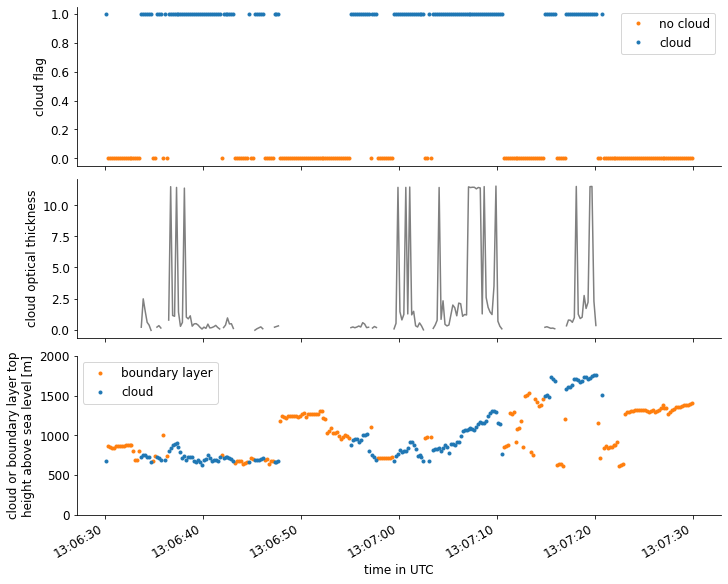

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True,
                                    constrained_layout=True)

ds_cloud_ll1.cloud_flag.sel(time=np.invert(mask_cloud)).plot(ax=ax1, x="time", ls="",
                                                             marker=".", color="C1",
                                                             label="no cloud")
ds_cloud_ll1.cloud_flag.sel(time=mask_cloud).plot(ax=ax1, x="time", ls="", marker=".",
                                                  color="C0", label="cloud")
ax1.set_ylabel(f"{ds_cloud_ll1.cloud_flag.long_name}")
ax1.legend()

ds_cloud_ll1.cloud_ot.plot(ax=ax2, x="time", color="grey")
ax2.set_ylabel(f"{ds_cloud_ll1.cloud_ot.long_name}")

ds_cloud_ll1.cloud_top.sel(time=np.invert(mask_cloud)).plot(ax=ax3, x="time", ls="",
                                                            marker=".", color="C1",
                                                            label="boundary layer")
ds_cloud_ll1.cloud_top.sel(time=mask_cloud).plot(ax=ax3, x="time", ls="", marker=".",
                                                 color="C0", label="cloud")
ax3.set_ylim(0, 2000)
ax3.set_ylabel("cloud or boundary layer top\nheight above sea level [m]")
ax3.legend()

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('time in UTC')
for ax in [ax1, ax2, ax3]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

### Cloud fraction

In [13]:
cf = np.sum(ds_cloud.cloud_flag.values==1) / ds_cloud.cloud_flag.size
cf_ot_gt_3 = np.sum(ds_cloud.cloud_ot.values > 3) / ds_cloud.cloud_flag.size
print(f"Total cloud fraction on Feb 5: {cf*100:.2f} %")
print(f"Fraction of clouds with optical thickness greater than 3: {cf_ot_gt_3*100:.2f} %")

Total cloud fraction on Feb 5: 39.92 %
Fraction of clouds with optical thickness greater than 3: 11.31 %


We can use a time averaging window to derive a cloud fraction from the `cloud_flag` variable and see how it varies over the course of the flight.

In [14]:
def fraction_from_flag(ds, timedelta):
    return ds.groupby_bins(group=ds.time,
                           bins=np.arange(ds.time.values[0],
                                          ds.time.values[-1],
                                          np.timedelta64(timedelta, "m"))
                          ).mean()

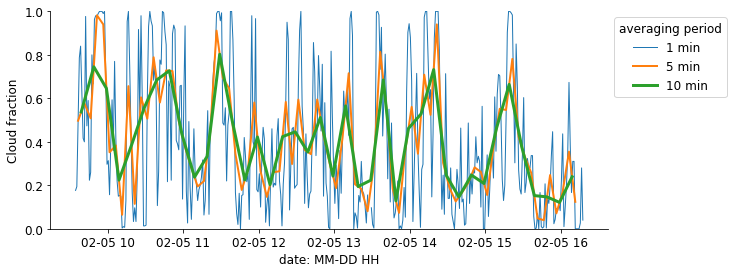

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))

for ind, t in enumerate([1, 5, 10]):
    fraction_from_flag(ds_cloud.cloud_flag, t).plot(lw=ind + 1, label=f"{t} min")

ax.set_ylim(0, 1)
ax.set_ylabel("Cloud fraction")
ax.set_xlabel("date: MM-DD HH")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(title="averaging period", bbox_to_anchor=(1,1), loc="upper left")